C:\Users\Admin\AppData\Local\Temp\ipykernel_22268\2276788948.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dew_data['dayofyear'] = dew_data['ds'].dt.dayofyear
C:\Users\Admin\AppData\Local\Temp\ipykernel_22268\2276788948.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dew_data['year'] = dew_data['ds'].dt.year


Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R² Score: 0.854
RMSE: 2.257
MAE: 1.464
Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}


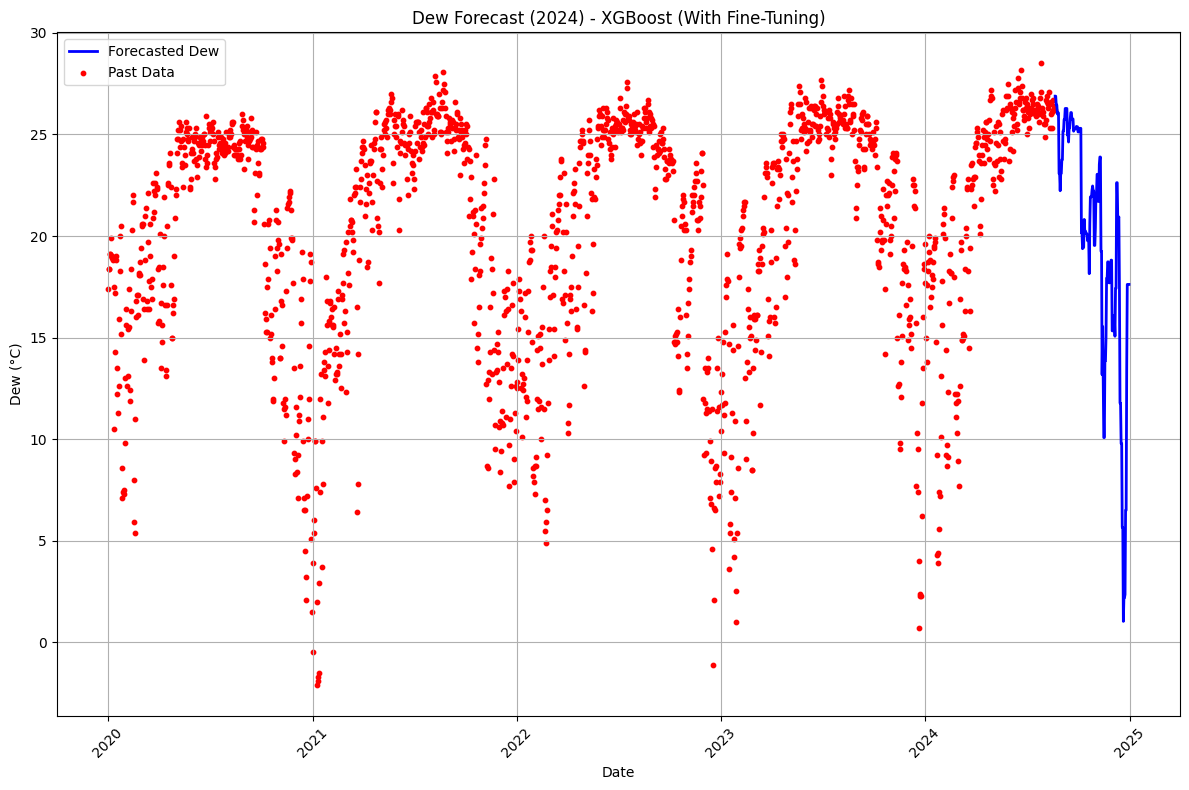

In [2]:
# Required imports
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../../dataset/data.csv'
data = pd.read_csv(file_path)

# Prepare the data (for XGBoost)
data['ds'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
dew_data = data[['ds', 'dew']]

# Extract features and labels
dew_data['dayofyear'] = dew_data['ds'].dt.dayofyear
dew_data['year'] = dew_data['ds'].dt.year
X = dew_data[['year', 'dayofyear']]
y = dew_data['dew']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

# Initialize and fit the XGBoost model (With Fine-Tuning)
xgb_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Predict on the test set (validation set)
y_pred = best_xgb_model.predict(X_test)

# Calculate R², RMSE, and MAE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Display the performance metrics
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Best Parameters: {grid_search.best_params_}")

# Generate future dates (from 21/08/2024 to 31/12/2024)
future_dates = pd.date_range('2024-08-21', '2024-12-31')
future_data = pd.DataFrame({
    'ds': future_dates,
    'dayofyear': future_dates.dayofyear,
    'year': future_dates.year
})

# Predict future dew
future_forecast = best_xgb_model.predict(future_data[['year', 'dayofyear']])
future_data['dew_forecast'] = future_forecast

# Display and save the predicted dew
future_data[['ds', 'dew_forecast']].tail()
future_data[['ds', 'dew_forecast']].to_csv('dew_forecast_xgb_tuned_2024.csv', index=False)

# Plot the forecasted dew
plt.figure(figsize=(12, 8))
plt.plot(future_data['ds'], future_data['dew_forecast'], color='blue', label='Forecasted Dew', linewidth=2)
plt.scatter(dew_data['ds'], dew_data['dew'], color='red', label='Past Data', s=10)
plt.title("Dew Forecast (2024) - XGBoost (With Fine-Tuning)")
plt.xlabel("Date")
plt.ylabel("Dew (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
